# 1. import libraries

In [1]:
#! pip install splitfolders
#! pip install python_splitter 
#! pip install cv2
#! pip install opencv-python==4.6.0.66
#! pip install dipy

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from sklearn.preprocessing import MinMaxScaler #to scale image pixels
import pandas as pd
from skimage.filters import gaussian
import cv2
from scipy.signal import convolve2d
from skimage import io, img_as_float
from skimage.segmentation import active_contour
import numpy as np
import matplotlib.pyplot as plt
from dipy.data import fetch_tissue_data, read_tissue_data
from dipy.segment.tissue import TissueClassifierHMRF
scaler = MinMaxScaler()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#import os
#os.chdir(r"/content/drive/My Drive")

# 2. initial understanding of the dataset

In [5]:
DATASET_PATH = "C:/Users/jasmine/Desktop/graduation project/data/"

#load single image as numpy array
test_image_AD=nib.load( DATASET_PATH+ "AD_T2/ADNI/002_S_0619/Axial_PD_T2_FSE/2006-06-01_20_16_38.0/S15207/ADNI_002_S_0619_MR_Axial_PD_T2_FSE__br_raw_20060605133200599_2_S15207_I16498.nii").get_fdata()   # fdata Extract data as numpy ndarray
print(test_image_AD.max())  # we know that we need scale max=,min=0
print(test_image_AD.min())
print(test_image_AD.shape) # get dimentions of image(height, width, depth, channel )

7472.0
0.0
(256, 256, 54, 1)


In [6]:

test_image_CN=nib.load(DATASET_PATH + "CN_T2/ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_38_08.0/S13404/ADNI_002_S_0295_MR_Axial_PD_T2_FSE__br_raw_20060418201017471_2_S13404_I13723.nii").get_fdata()

test_image_MCI=nib.load(DATASET_PATH + "MCI_T2/ADNI/002_S_0729/Axial_PD_T2_FSE/2006-07-17_13_45_42.0/S16873/ADNI_002_S_0729_MR_Axial_PD_T2_FSE__br_raw_20060718015550509_2_S16873_I19059.nii").get_fdata()

print("AD MAX",test_image_AD.max()) 
print("AD SHAPE",test_image_AD.shape)
print("CN MAX",test_image_CN.max())  
print("CN SHAPE",test_image_CN.shape)
print("MCI MAX",test_image_MCI.max())  
print("MCI SHAPE",test_image_MCI.shape)
print("type",type(test_image_AD),type(test_image_CN),type(test_image_MCI))


AD MAX 7472.0
AD SHAPE (256, 256, 54, 1)
CN MAX 7270.0
CN SHAPE (256, 256, 52, 1)
MCI MAX 7843.0
MCI SHAPE (256, 256, 48, 1)
type <class 'numpy.memmap'> <class 'numpy.memmap'> <class 'numpy.memmap'>


### visualization

In [7]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 8))
    plt.subplot(231)
    plt.imshow(test_image_CN[:,:,layer])
    plt.title('CN')
    plt.subplot(232)
    plt.imshow(test_image_MCI[:,:,layer])
    plt.title('MCI')
    plt.subplot(233)
    plt.imshow(test_image_AD[:,:,layer])
    plt.title('AD')
    plt.show()
    return layer

In [8]:

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0,47)); 

interactive(children=(IntSlider(value=23, description='layer', max=47), Output()), _dom_classes=('widget-inter…

# 3. preprocceing

## 3.1 slicing

In [9]:
def slicer(image):
    slice_index= range(image.shape[2])
    for ind in slice_index:
        slice_=image[:,:,slice_index[ind]]
        
        
        plt.figure(figsize=(5, 5))
        plt.imshow(slice_, cmap='gray')
    plt.show()

    
    ########### perform preprocceing on each slice separetly and saving it ##########


    

## 3.2 skull stripping

In [10]:
def gausian_filter (image):
    gaussian_smoothed = gaussian(image)
    return gaussian_smoothed
################################################

def apply_conv(image,kernel):
    conv_ = cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    return conv_
#################################################
def threshold(image):
    image_ = image.astype(np.uint16)
    thresh = cv2.threshold(image_, 254, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
    return thresh
#################################################
def contour(image):
    immmm = image.astype(np.uint8)
    countours , _ = cv2.findContours(immmm,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    shape = image.copy()
    cv2.drawContours(shape, countours, -1, (0, 255, 0), 2)
    return shape


In [11]:
def skull_stripping(image):

    kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 3*3 kernel
    gaussian_smoothed =gausian_filter(image) #I1
    conv_ = apply_conv(gaussian_smoothed,kernel) #I2
    th = threshold(conv_)
    erosion = cv2.erode(th,kernel,iterations = 1) #I3
    contour_=contour(erosion) #I4

    out=image*contour_ #I5

    return out

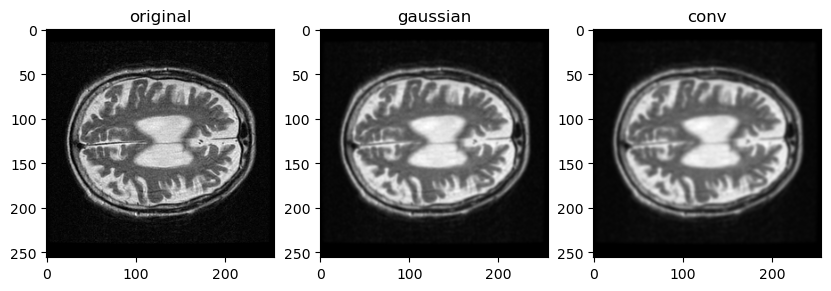

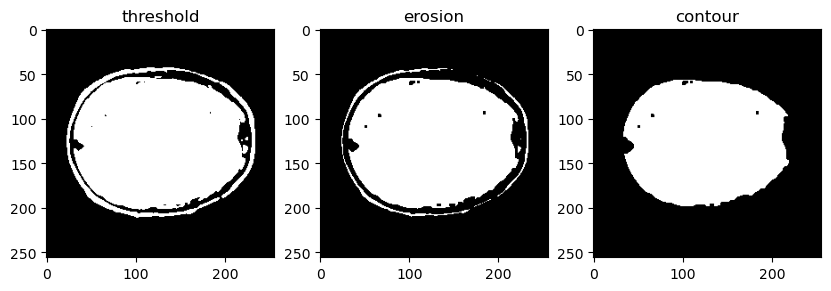

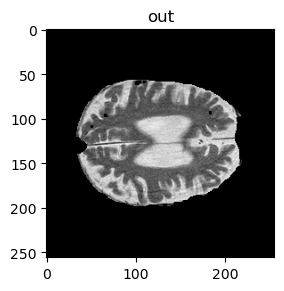

In [12]:
image = test_image_AD[:,:,35,0]


kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 3*3 kernel
gaussian_smoothed =gausian_filter(image) #I1
conv_ = apply_conv(gaussian_smoothed,kernel) #I2
th = threshold(conv_)
erosion = cv2.erode(th,kernel,iterations = 1) #I3
contour_=contour(erosion)

out=image*contour_ #I5


plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.imshow(image, cmap='gray')
plt.title('original')
plt.subplot(232)
plt.imshow(gaussian_smoothed, cmap='gray')
plt.title('gaussian')
plt.subplot(233)
plt.imshow(conv_, cmap='gray')
plt.title('conv')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.imshow(th, cmap='gray')
plt.title('threshold')
plt.subplot(232)
plt.imshow(erosion,cmap='gray')
plt.title('erosion')
plt.subplot(233)
plt.imshow(contour_, cmap='gray')
plt.title('contour')
plt.show()


plt.figure(figsize=(10, 10))
plt.subplot(231)
plt.imshow(out,cmap='gray')
plt.title('out')

plt.show()


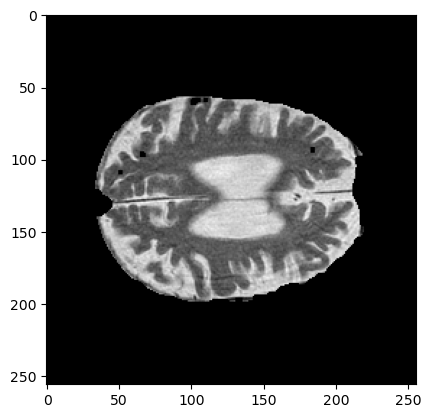

In [45]:
#immmmmm=skull_stripping(image)
im=skull_stripping(image)
plt.imshow(im,cmap="gray")
plt.show()

In [74]:
nclass = 2
beta = 0.05

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
>> Iteration: 10
>> Iteration: 11
>> Iteration: 12
>> Iteration: 13
>> Iteration: 14
>> Iteration: 15
>> Iteration: 16
>> Iteration: 17
>> Iteration: 18
>> Iteration: 19
>> Iteration: 20
>> Iteration: 21
>> Iteration: 22
>> Iteration: 23
>> Iteration: 24
>> Iteration: 25
>> Iteration: 26
>> Iteration: 27
>> Iteration: 28
>> Iteration: 29
>> Iteration: 30
>> Iteration: 31
>> Iteration: 32
>> Iteration: 33
>> Iteration: 34
>> Iteration: 35
>> Iteration: 36
>> Iteration: 37
>> Iteration: 38
>> Iteration: 39
>> Iteration: 40
>> Iteration: 41
>> Iteration: 42
>> Iteration: 43
>> Iteration: 44
>> Iteration: 45
>> Iteration: 46
>> Iteration: 47
>> Iteration: 48
>> Iteration: 49
>> Iteration: 50
>> Iteration: 51
>> Iteration: 52
>> Iteration: 53
>> Iteration: 54
>> Iteration: 55
>> Iteration: 56
>> Iteration: 57
Total time:2.45419836044

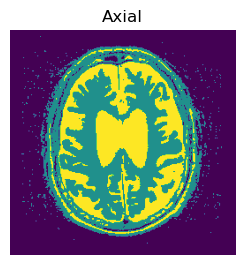

In [75]:
import time
t0 = time.time()

hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(test_image_AD[:,:,35], nclass, beta)

t1 = time.time()
total_time = t1-t0
print('Total time:' + str(total_time))

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
img_ax = np.rot90(final_segmentation[..., 0])
imgplot = plt.imshow(img_ax)
a.axis('off')
a.set_title('Axial')

plt.savefig('final_seg.png', bbox_inches='tight', pad_inches=0)

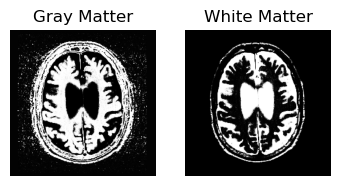

In [77]:
fig = plt.figure()

a = fig.add_subplot(1, 3, 2)
img_cor = np.rot90(PVE[:, :, 0, 0])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('Gray Matter')
a = fig.add_subplot(1, 3, 3)
img_cor = np.rot90(PVE[:, :, 0, 1])
imgplot = plt.imshow(img_cor, cmap="gray")
a.axis('off')
a.set_title('White Matter')
plt.savefig('probabilities.png', bbox_inches='tight', pad_inches=0)
plt.show()